# PW9: Variational Autoencoder

Objective: Generate images using a Variational AutoEncoder and analyze the latent space



In [ ]:
import tensorflow.keras as tk
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

from tensorflow.keras.layers import Input, Dense, Lambda, Flatten, Reshape, Conv2D, Conv2DTranspose,BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras import metrics

# Data
[Fashion MNIST](https://github.com/zalandoresearch/fashion-mnist) is a dataset containing 70 000 28$\times$ 28 gray level images from 10 categories  (	T-shirt/top, Trouser, Pullover, Dress, Coat, Sandal, Shirt, Sneaker, Bag, Ankle boot) from Zalando articles. 60 000 images compose the training set, and the 10 000 remaining ones are for testing.

In [ ]:
(x_train, y_train), (x_test, y_test) = tk.datasets.fashion_mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

labels = {0: "T-shirt", 1: "Trousers", 2: "Pull", 3: "Dress", 4: "Coat", 
          5: "Sandal", 6: "Shirt", 7: "Sneaker", 8: "Bag", 9: "Ankle boot"}

4423680/4422102 [==============================] - 0s 0us/step


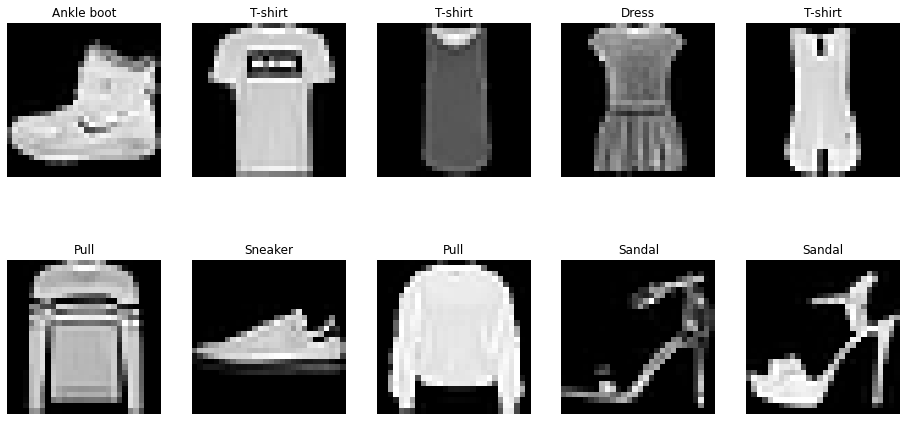

In [ ]:
plt.figure(figsize=(16, 8))
for i in range(0, 10):
    plt.subplot(2, 5, i + 1)
    plt.title(labels[y_train[i]])
    plt.imshow(x_train[i], cmap="gray")
    plt.axis("off")
plt.show()

# Models
Two models are developed in the following:
- A very basic one where the encoder and the decoder are MLPs
- A second one based on CNNs

Use the [Model](https://keras.io/api/models/model/) class to create all the networks (encoders and decoders). An example is provided for the encoder of the MLP-based VAE, try to reproduce for the 3 remaining nets.

## MLP-based VAE



### Reshaping the data

In [ ]:
x_train_MLP = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test_MLP = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

### Encoder definition
The encoder is a MLP composed of 1 hidden layer with size `hidden_dim` and ReLU activation, followed by two parallel output layers of size `latent_dim`, modeling the mean and the variance of the distribution in the latent space.


In [ ]:
dim = 784
latent_dim = 10
hidden_dim = 256


def Encoder(dim, hidden_dim, latent_dim):
    x = Input(shape=(dim,))
    hidden = Dense(hidden_dim, activation='relu')(x)
    z_mean = Dense(latent_dim)(hidden)
    z_log_var = Dense(latent_dim)(hidden)
    return Model(inputs=x, outputs=[z_mean, z_log_var],name="Encoder_MLP")
    
encoder = Encoder(dim, hidden_dim, latent_dim)

### Latent space

Let $z$ be a random variable $ z \sim \mathcal{N}(\mu_z(x), \sigma_z(x)) $ conditioned to the input $x$. 

We use the reparametrization trick in order to allow efficient backpropagation $ z = \mu_z(x) + \sigma_z(x) \cdot \epsilon$, where  $ \epsilon \sim \mathcal{N}(0, 1) $

The output of the encoder parametrizes $log(\sigma^2_z(x))$ instead of   $\sigma_z(x)$ (ensures the positivity of the variance) $\sigma^2_z(x)$.

In [ ]:
def sample(inputs):
    z_mean, z_log_var = inputs
    batch_size = K.shape(z_mean)[0]
    epsilon = K.random_normal(shape=(batch_size, latent_dim),mean=0., stddev=1.)
    return z_mean + K.exp(z_log_var / 2) * epsilon

sampling_layer = Lambda(sample, output_shape=(latent_dim,),name="latent")

### Decoder
The decoder start from the latent space, then includes a layer with `hidden_dim` units and ReLU activation, and output a layer of size (dim(x)) with sigmoïd activation.

In [ ]:
def Decoder(latent_dim, hidden_dim, dim):
  #TODO 

decoder = Decoder(latent_dim, hidden_dim, dim)

To illustrate: give the decoder a random latent vector to see the output (weights and biases of the decoder are not trained yet)
The random latent vector can be created with the [np.random.normal](https://numpy.org/doc/stable/reference/random/generated/numpy.random.normal.html) function
If img is the image generated by the decoder, then display using `plt.imshow(ìmg.reshape(28, 28), cmap=plt.cm.gray)`

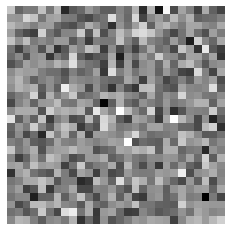

In [ ]:
#TODO
plt.axis('off');

### VAE
From the previous MLP, build the VAE :
- Encoder
- Sampling layer, drawing mean and variance
- Decoder

We provide the computation of the loss function, as well as the definition of the optimizer

In [ ]:
def VAE(input_shape, encoder, decoder, sampling_layer):

    #TODO

    # Loss function
    xent_loss = dim * metrics.binary_crossentropy(K.flatten(x), K.flatten(x_decoded_mean))
    kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    vae_loss = K.mean(xent_loss + kl_loss)

    vae.add_loss(vae_loss)
    vae.compile(optimizer='adam')
    return vae

vae = VAE((dim,), encoder, decoder,sampling_layer=sampling_layer)





Train the VAE and save the weights for further use (with the [save_weights](https://keras.io/api/models/model_saving_apis/) function)

In [ ]:
#Once trained, can comment the two next lines
vae.fit(x_train_MLP, epochs=100, batch_size=100,validation_data=(x_test_MLP, None))
vae.save_weights("VAE_classic_weights.h5")
vae.load_weights("VAE_classic_weights.h5")

Epoch 1/100
600/600 [==============================] - 2s 3ms/step - loss: 327.3232 - val_loss: 259.7149
Epoch 2/100
600/600 [==============================] - 1s 2ms/step - loss: 255.4959 - val_loss: 253.0121
Epoch 3/100
600/600 [==============================] - 1s 2ms/step - loss: 251.5876 - val_loss: 250.8454
Epoch 4/100
600/600 [==============================] - 1s 2ms/step - loss: 248.2636 - val_loss: 248.8724
Epoch 5/100
600/600 [==============================] - 2s 3ms/step - loss: 247.0208 - val_loss: 247.9861
Epoch 6/100
600/600 [==============================] - 2s 3ms/step - loss: 246.0752 - val_loss: 247.1977
Epoch 7/100
600/600 [==============================] - 2s 3ms/step - loss: 245.1115 - val_loss: 246.6375
Epoch 8/100
600/600 [==============================] - 2s 3ms/step - loss: 245.3590 - val_loss: 245.7628
Epoch 9/100
600/600 [==============================] - 1s 2ms/step - loss: 243.8317 - val_loss: 245.3860
Epoch 10/100
600/600 [==============================] -

Now that the VAE is trained, use the decoder to generate an image, from a latent vector.

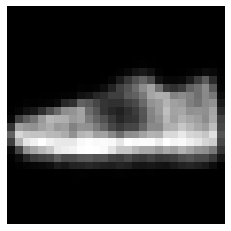

In [ ]:
#TODO: same thing than before, but now the decoder is trained.

Use the model on the test set to display real and reconstructed images

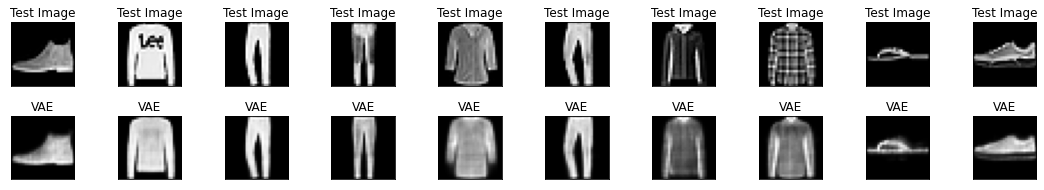

In [ ]:
x_test_decoded_vae = vae.predict(x_test_MLP, batch_size= 100)

n = 10  
plt.figure(figsize=(15, 4))
for i in range(n):
    ax = plt.subplot(3, n, i + 1)
    plt.title('Test Image')
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    

    ax = plt.subplot(3, n, i + 1 + n)
    plt.title('VAE')
    plt.imshow(x_test_decoded_vae[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.tight_layout()

### Understanding the latent space

if `latent_dim`is set to 2, we can use te encoder to project the images onto a plane. And if we color-code the 2D point with its class, we can visualize the distribution of the classes in the latent space.

In [ ]:
latent_dim = 2
encoder = Encoder(dim, hidden_dim, latent_dim)
sampling_layer = Lambda(sample, output_shape=(latent_dim,),name="Sampler_latent")
decoder = Decoder(latent_dim, hidden_dim, dim)
vae = VAE((dim,), encoder, decoder,sampling_layer=sampling_layer)

#Once trained, can comment the two next lines
vae.fit(x_train_MLP, epochs=100, batch_size=100,validation_data=(x_test_MLP, None))
vae.save_weights("VAE_classic_weights_2D.h5")
vae.load_weights("VAE_classic_weights_2D.h5")

Epoch 1/100
600/600 [==============================] - 2s 3ms/step - loss: 352.0883 - val_loss: 282.0272
Epoch 2/100
600/600 [==============================] - 1s 2ms/step - loss: 278.9173 - val_loss: 275.5306
Epoch 3/100
600/600 [==============================] - 1s 2ms/step - loss: 273.0837 - val_loss: 272.1840
Epoch 4/100
600/600 [==============================] - 1s 2ms/step - loss: 270.6470 - val_loss: 271.4029
Epoch 5/100
600/600 [==============================] - 1s 2ms/step - loss: 268.1103 - val_loss: 268.6914
Epoch 6/100
600/600 [==============================] - 1s 2ms/step - loss: 267.4567 - val_loss: 267.6486
Epoch 7/100
600/600 [==============================] - 1s 2ms/step - loss: 266.1804 - val_loss: 266.9283
Epoch 8/100
600/600 [==============================] - 1s 2ms/step - loss: 265.7044 - val_loss: 266.6546
Epoch 9/100
600/600 [==============================] - 1s 2ms/step - loss: 264.4769 - val_loss: 266.1355
Epoch 10/100
600/600 [==============================] -

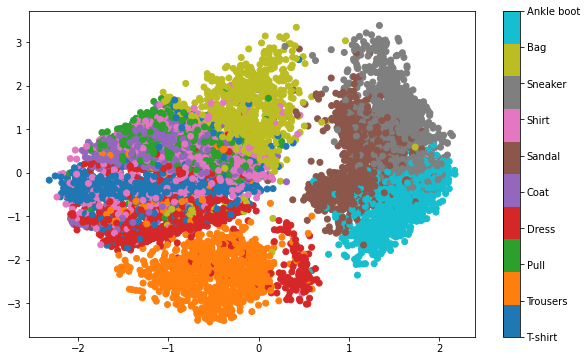

<Figure size 432x288 with 0 Axes>

In [ ]:
x_test_encoded, x_test_encoded_log_var = encoder.predict(x_test_MLP, batch_size=100)
plt.figure(figsize=(10, 6))
plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=y_test,cmap=plt.cm.tab10)
cb = plt.colorbar()
cb.set_ticks(list(labels.keys()))
cb.set_ticklabels(list(labels.values()))
cb.update_ticks()
plt.show()
plt.tight_layout()

Sandal, Sneaker and Ankle boots form a separate cluster.
T-shirt, Coat and Shirt are also very intricated.

The unit square can be tranformed using the inverse conditional distribution of the Gaussian to visualize the latent space and the manifold on which the examples lie

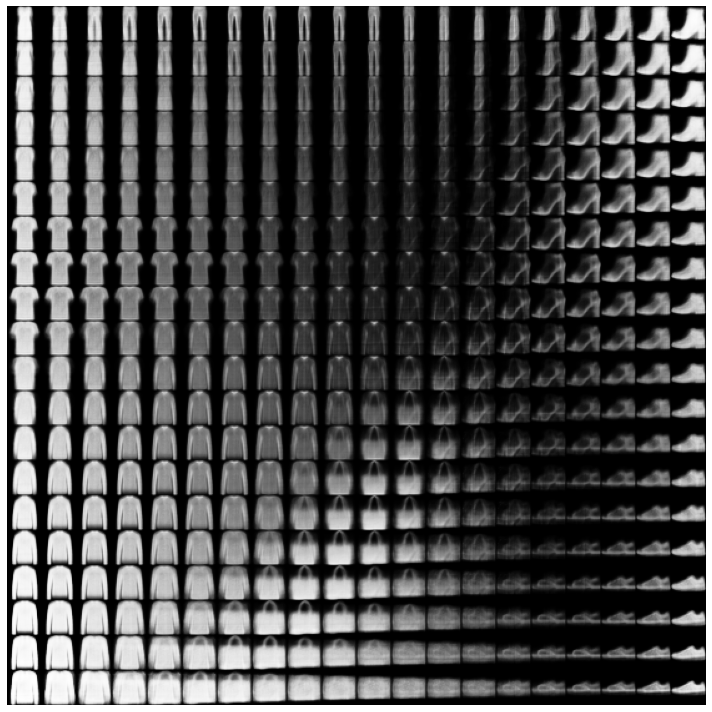

In [ ]:
n = 20  
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        x_decoded = decoder.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='Greys_r')
plt.axis('off')
plt.tight_layout()

## CNN-based VAE

Prepare data

In [ ]:
x_train_CNN = np.expand_dims(x_train, -1)
x_test_CNN = np.expand_dims(x_test, -1)

### Encoder

Build the following encoder
- Input layer
- [Convolution](https://keras.io/layers/convolutional/) layer, `filters` filters of size `kernel_size`,  ReLU activation
- [Normalisation](https://keras.io/layers/normalization/) layer
- [Convolution](https://keras.io/layers/convolutional/) layer, `filters` filters of size  `kernel_size`, ReLU activation and (2,2) strides
- [Normalisation](https://keras.io/layers/normalization/) layer
- [Convolution](https://keras.io/layers/convolutional/) `filters` filters of size `kernel_size`,  ReLU activation
- [Normalisation](https://keras.io/layers/normalization/) layer
- [Convolution](https://keras.io/layers/convolutional/) l`filters` filters of size `kernel_size`,  ReLU activation and  (2,2) strides
- [Flatten](https://keras.io/layers/core/) layer
- [Dense](https://keras.io/layers/core/) layer,  ReLU activation
- [Dense](https://keras.io/layers/core/) layer for the mean of  $z$
- [Dense](https://keras.io/layers/core/) layer for the variance of $z$

The dimensions must fit to the problem.
`latent_dim` is set to 2 for a 2D representation. To allow a better image generation, it must be increased (but no 2D representation is possible if >3)

In [ ]:
img_rows, img_cols, img_chns = 28, 28, 1
filters = 32
kernel_size = 3
hidden_dim = 128

latent_dim = 2

def CEncoder(img_rows, img_cols, img_chns,latent_dim, hidden_dim):
  #TODO


cencoder = CEncoder(img_rows, img_cols, img_chns,latent_dim, hidden_dim)

Same latent space

In [ ]:
sampling_layer = Lambda(sample, output_shape=(latent_dim,),name="latent")

## Decoder

Here is the architecture  to reproduce, with `spatial_size`=7 and `filters`=16
- Input layer
- Dense layer of size `hidden_dim`,  ReLU activation
- Dense layer of size `filters * spatial_size * spatial_size`,  ReLU activation
- Transposed convolution layer([Conv2DTranspose](https://keras.io/layers/convolutional/filters)), `filters ` filters of size 3,  (2,2) strides,  ReLU activation
- Normalisation layer
- Transposed convolution layer([Conv2DTranspose](https://keras.io/layers/convolutional/filters)), `filters` filters of size 3,  (2,2) strides,  ReLU activation
- Normalisation layer
- Transposed convolution layer([Conv2DTranspose](https://keras.io/layers/convolutional/filters)), `filters`filters of size 3,  (2,2) strides,  ReLU activation
- Normalisation layer
- [Convolution](https://keras.io/layers/convolutional/) layer, 1 filters of size 2,  sigmoid activation


In [ ]:
def CDecoder(latent_dim, hidden_dim, dim,spatial_size=7, filters=16):
  #TODO


cdecoder = CDecoder(latent_dim, hidden_dim, dim,spatial_size=7, filters=filters)

Generate an image from a random vector

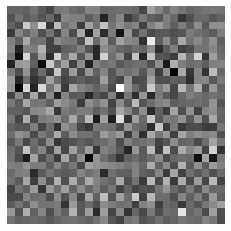

In [ ]:
#TODO

Build and train the corresponding VAE


In [ ]:
input_shape = (img_rows, img_cols, img_chns)
cvae = VAE(input_shape, cencoder, cdecoder,sampling_layer)
cvae.summary()
#Once trained, can comment the two next lines
cvae.fit(x_train_CNN, epochs=15, batch_size=100,validation_data=(x_test_CNN, None))
cvae.save_weights("convolutional_weights.h5")
cvae.load_weights("convolutional_weights.h5")

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
CEncoder (Functional)           [(None, 2), (None, 2 229796      input[0][0]                      
__________________________________________________________________________________________________
latent (Lambda)                 (None, 2)            0           CEncoder[1][0]                   
                                                                 CEncoder[1][1]                   
__________________________________________________________________________________________________
CDecoder (Functional)           (None, 28, 28, 1)    230913      latent[1][0]               



Image generation

In [1]:
#TODO

Comparison test set / MLP-based VAE / CNN-based VAE

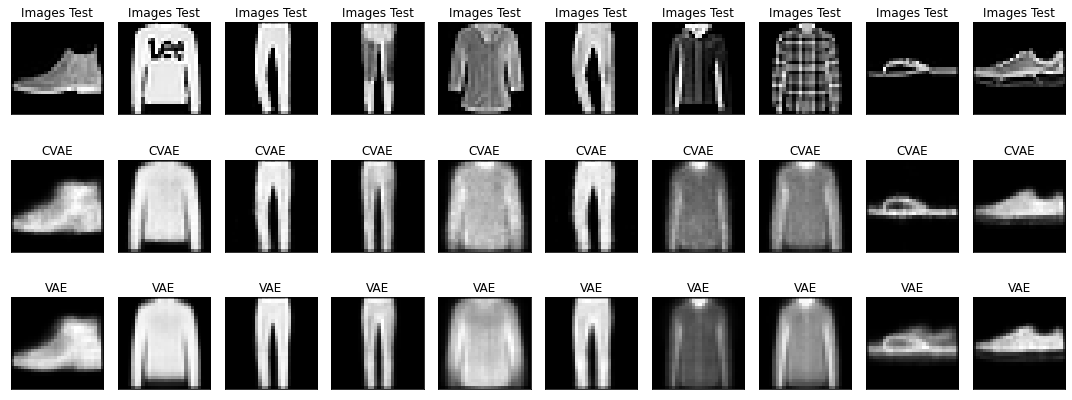

In [ ]:
x_test_decoded_cvae = cvae.predict(x_test_CNN, batch_size= 100)
x_test_decoded_vae = vae.predict(x_test_MLP, batch_size= 100)

n = 10 
plt.figure(figsize=(15, 6))
for i in range(n):
    ax = plt.subplot(3, n, i + 1)
    plt.title('Images Test')
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    ax = plt.subplot(3, n, i + 1 + n)
    plt.title('CVAE')
    plt.imshow(x_test_decoded_cvae[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    ax = plt.subplot(3, n, i + 1 + 2*n)
    plt.title('VAE')
    plt.imshow(x_test_decoded_vae[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.tight_layout()

### 2D projection

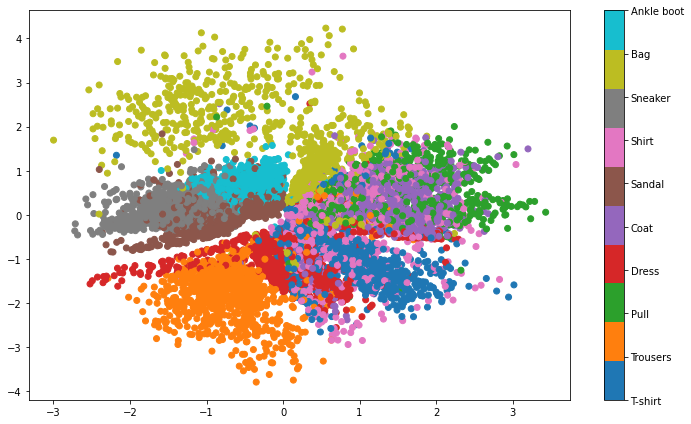

In [ ]:
x_test_encoded, _ = cencoder.predict(x_test_CNN, batch_size=100)
plt.figure(figsize=(10, 6))
plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=y_test,cmap=plt.cm.tab10)
cb = plt.colorbar()
cb.set_ticks(list(labels.keys()))
cb.set_ticklabels(list(labels.values()))
cb.update_ticks()
plt.tight_layout()

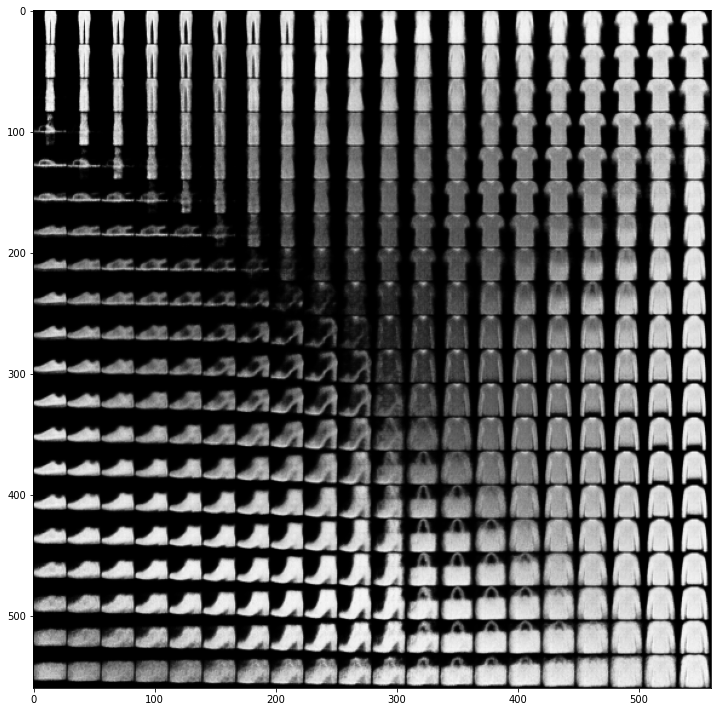

In [ ]:
n = 20  
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        x_decoded = cdecoder.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='Greys_r')
plt.tight_layout()